### **Notebook to make predictions with reprocessed Yoneda and Henson data and EFLUX2 and SPOT** 

##### **Import python packages**

In [235]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
#import cplex
%matplotlib inline
from matplotlib import pyplot as plt
from edd_utils import login, export_study, export_metadata

##### **Load data**

In [236]:
# Study to Download
study_slug = 'biodesign_henson2018_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [239]:
session = login(edd_server=edd_server, user=user)

Password for schenkch:  ···············


In [240]:
df = export_study(session, study_slug, edd_server=edd_server)
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Filter data from all EDD data into different dataframes**

In [241]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Load Genome Scale Model**

In [242]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import Joonhoons Code**

In [243]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from eflux2 import EFlux2
from spot_cplex import SPOT #spot not working yet because quadratic constraints not supported yet

##### Change gene annotation from WP... to G_WP..., such that the model and dataframe annotations match

In [244]:
# df_Trans2 = df_Trans.copy()
# df_Trans2.loc[:,'Measurement Type'] = df_Trans2.loc[:,'Measurement Type'].apply(lambda x: x.replace('WP', 'G_WP'))

In [245]:
# display(df_Trans2)

##### Prepare data frame with correct format

In [246]:
df_TransPhe = df_Trans[df_Trans['Line Description'].str.contains('0.5 g/l PHE as carbon source')]
df_TransPhe
df_TransWTPR1 = df_TransPhe[df_TransPhe['Line Name']=='WT-P-R1']
df_TransWTPR1
df_TransWTPR1new=df_TransWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
df_TransWTPR1new
df_TransWTPR1new2 = df_TransWTPR1new.set_index('Measurement Type')
df_TransWTPR1new2

,Value
Measurement Type,
WP_000104864_1,0.00000
WP_000516288_1,0.00000
WP_000538659_1,0.00000
WP_001245922_1,0.00000
WP_001297013_1,0.08791
WP_001564525_1,0.00000
WP_002310911_1,0.00000
WP_002670777_1,0.00000
WP_003402602_1,472.16356


#### **EFLUX2 and SPOT Predictions**

In [247]:
from optlang.symbolics import add
"""
    Provides EFLUX2 predictions as explained in Machado et. al (2014) 
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.
        
        Returns
        -------
        eflux2_sol as output from eflux2_model.optimize().
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def EFlux2test(model, Transcriptomics):
    #with model as eflux2_model:
    eflux2_model = model.copy()
    # Parse GPR into a dict containing isozymes (separated by 'or')
    # Each isozyme has a set of subunits (separated by 'and')
    #'and' and 'or' can occur at the same time, or can occur by itself.
    gpr_dict = dict()
    for r in eflux2_model.reactions:
        if r.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[r.id] = temp
    xg = []
    t2 = 0
    nontranslblist = []
    nontransublist = []
    # Set the bounds using the transcriptomics data    
    for r in eflux2_model.reactions:
        if r.gene_reaction_rule:
            t = 0
            #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
            #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
            #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
#             t = np.sum([np.min([Transcriptomics.loc[g].values if g in Transcriptomics.index
#                                 else np.array([np.Inf]) for g in p])
#                         for p in gpr_dict[r.id]])
            for p in gpr_dict[r.id]:
                xg=[]
                for g in p:
                    if g in Transcriptomics.index:

                        xg.append(Transcriptomics.loc[g].values)
                    else:
                        xg.append(np.Inf)
                    t1=np.min(xg)
                t = t + t1
#             if t2!=t:
#                 display('difference',t2, t)
#             if t != np.inf:
#                 display(t)
            if r.lower_bound < 0.0:
                r.lower_bound = -t
            else:
                pass
            if r.upper_bound > 0.0:
                r.upper_bound = t
            else:
                pass
        else:
            #When there is no GPR, the arbitrary bounds are removed. 
            #Common arbitrary bound value of 1000 for E.coli, might be different depending on the model, e.g., 99999.0 for iMM904 yeast model in BiGG
            if r.lower_bound <= -1000:
                r.lower_bound = -np.Inf
                nontranslblist.append(r.id)
            if r.upper_bound >= 1000:
                r.upper_bound = np.Inf 
                nontransublist.append(r.id)
    display('not-transcript bound changed:lb',nontranslblist)
    display('not-transcript bound changed:lub',nontransublist)
    display(eflux2_model.medium)
    
    # solve FBA to calculate the maximum biomass
    eflux2_model.tolerance = 1e-9
    fba_sol = eflux2_model.optimize()
    print('FBA status', fba_sol.status)
    print('FBA solution', fba_sol.objective_value)
    display(eflux2_model.objective)
    
    # Constrain the biomass to the optimal value
    for r in eflux2_model.reactions:
        if r.objective_coefficient:
            r.lower_bound = fba_sol.objective_value
            
    # minimize the sum of squared flux values
    eflux2_model.objective = eflux2_model.problem.Objective(add([r.flux_expression**2 for r in eflux2_model.reactions]), direction='min')
    display(eflux2_model.problem.Objective)
    eflux2_sol = eflux2_model.optimize()
    print('EFlux2 status', eflux2_sol.status)
    print('EFlux2 solution', eflux2_sol.objective_value)
    
    return eflux2_sol

##### **Non modularized way ( Can be removed when we know that it works!!!)**

In [248]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium = {key:np.Inf for (key,value) in model.medium.items()}
    medium["EX_glc__D_e"] = 0.0
    medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    eflux2sol_WTPR1 = EFlux2test(model, df_TransWTPR1new2)
    
    #display(df_TransWTPR1new2)
    #spotsolWTPR1 = SPOT(model, df_TransWTPR1)
    #display(spotsolWTPR1)
#         else:
# #             model.objective = 'Growth_Glucose'
#             model.objective = 'Growth'
#             sub_uptake_rate = 1.76124#growthandsubstrdata.loc[index,'substrate_consumption_rate']
#             medium["EX_glc__D_e"] = sub_uptake_rate
#             medium["EX_phenol_e"] = 0.0
#             #print(index)
#             #print(index)
#         model.medium = medium

'not-transcript bound changed:lb'

['2HXMPt6',
 '2PGLYCt6',
 '34DHCINMtex',
 '34DHCINMtpp',
 '3MBtex',
 '4HBZtex',
 '4OT',
 '4OT2',
 '4PEPTtex',
 '5MTRt2',
 'A5PISO',
 'ACGAtex',
 'ACSERtex',
 'ACYSBMNt',
 'ADtr',
 'AGPATr_BS',
 'AHSERL4',
 'AKGDa',
 'ALATA_D',
 'ALAtex',
 'AMANAPEr',
 'AMPtex',
 'ANHGMtex',
 'ARACHTA',
 'ARAI',
 'ASO3tex',
 'ASO4rt2rpp',
 'ASO4tex',
 'BALAtex',
 'BMNt',
 'BUTSO3tex',
 'BZSS',
 'BZtex',
 'CA2tex',
 'CD2tex',
 'CGLYtex',
 'CHLtex',
 'CITtex',
 'CLt3r_2',
 'CMPtex',
 'CONFRLtex',
 'CONFRLtpp',
 'COt',
 'CREStex',
 'CRNtex',
 'CUtex',
 'DAMPtex',
 'DCAtex',
 'DCMPtex',
 'DGMPtex',
 'DINStex',
 'DSERtex',
 'DTMPtex',
 'DURItex',
 'E4PD',
 'ECHH_0',
 'ETHSO3tex',
 'F6PA',
 'FOLt',
 'FRUtex',
 'FUMtex',
 'G3PGtex',
 'GALCTNLtex',
 'GALCTNtex',
 'GALKr',
 'GLCtex',
 'GLCURS1',
 'GLNtex',
 'GLYBtex',
 'GLYtex',
 'GMPtex',
 'GUI1',
 'GUI2',
 'HACD9',
 'HCO3tex',
 'HG2tex',
 'HGt',
 'HISt2rpp',
 'HOXPRx',
 'HQNt6',
 'HYDFDN2r',
 'ILEt2rpp',
 'IMPtex',
 'ISETACtex',
 'LEUt4rpp',
 'M1PD',
 'MALDtex

'not-transcript bound changed:lub'

['12DGR120tipp',
 '12DGR140tipp',
 '12DGR141tipp',
 '12DGR161tipp',
 '12DGR180tipp',
 '12DGR181tipp',
 '14GLUCANtexi',
 '2AGPE120tipp',
 '2AGPE140tipp',
 '2AGPE141tipp',
 '2AGPE161tipp',
 '2AGPE180tipp',
 '2AGPE181tipp',
 '2AGPG120tipp',
 '2AGPG140tipp',
 '2AGPG141tipp',
 '2AGPG160tipp',
 '2AGPG161tipp',
 '2AGPG180tipp',
 '2AGPG181tipp',
 '2HXMPt6',
 '2PGLYCt6',
 '34DHCINMtex',
 '34DHCINMtpp',
 '3HAD100',
 '3HAD120',
 '3HAD121',
 '3HAD140',
 '3HAD141',
 '3HAD160',
 '3HAD161',
 '3HAD180',
 '3HAD181',
 '3HAD40',
 '3HAD60',
 '3HAD80',
 '3MBtex',
 '4HBALDt2pp',
 '4HBZtex',
 '4HTHRK',
 '4OT',
 '4OT2',
 '4PCP',
 '4PEPTtex',
 '5CM2HMUDI',
 '5DOAN',
 '5MTRt2',
 'A5PISO',
 'AB6PGH',
 'ACGAMK',
 'ACGAtex',
 'ACM6PH',
 'ACPPAT120',
 'ACPPAT140',
 'ACPPAT141',
 'ACPPAT160',
 'ACPPAT161',
 'ACPPAT180',
 'ACPPAT181',
 'ACSERtex',
 'ACYSBMNt',
 'ADADir',
 'ADMDC',
 'ADtr',
 'AGM3PApp',
 'AGM3Pt2pp',
 'AGM4PApp',
 'AGM4Pt2pp',
 'AGMHE',
 'AGPATr_BS',
 'AHSERL4',
 'AKGDa',
 'ALATA_D',
 'ALATA_L2',
 'AL

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': 1.76124}

FBA status optimal
FBA solution 0.15657969288612705


optlang.cplex_interface.Objective

EFlux2 status optimal
EFlux2 solution 509.24372838092313


In [249]:
display(eflux2sol_WTPR1.fluxes)

12DGR120tipp        0.00000
12DGR140tipp        0.00000
12DGR141tipp        0.00000
12DGR161tipp        0.00000
12DGR180tipp        0.00000
                     ...   
EX_phenol_e        -1.76124
phenol_transport    1.76124
PHEMOX              1.76124
Growth_Phenol       0.15658
Growth_Glucose      0.00000
Name: fluxes, Length: 2385, dtype: float64

In [250]:
eflux2sol_WTPR1_df = pd.DataFrame(eflux2sol_WTPR1.fluxes, columns=['fluxes'])

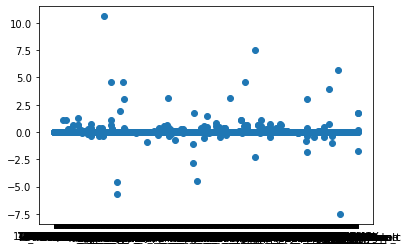

In [251]:
plt.scatter(eflux2sol_WTPR1_df.index,eflux2sol_WTPR1_df.fluxes)
plt.show()

##### Just linear scale up to solution to see how it compares:

In [252]:
testscaleeflux2 = eflux2sol_WTPR1_df*(100/1.76124)

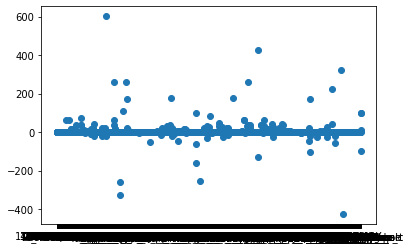

In [253]:
plt.scatter(testscaleeflux2.index,testscaleeflux2.fluxes)
plt.show()

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [254]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 29 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648


### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [255]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [256]:
EFLUX2_fluxes = []
#SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_eflux2 = 0
    #flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_eflux2 += min([get_flux_value(v, testscaleeflux2) for v in and_split])
        #flux_value_spot += min([get_flux_value(v,spotsoldf) for v in and_split])
    EFLUX2_fluxes.append(flux_value_eflux2)
    #SPOT_fluxes.append(flux_value_spot)
    
phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
#phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000,1.000000e+02
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459,1.629935e+01
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800,1.092978e+02
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800,1.092978e+02
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800,1.092978e+02
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305,5.528266e+01
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536,1.665644e+02
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305,1.699627e+02
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762,1.763120e+02
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648,1.763197e+02


### Plot EFLUX2 vs 13C MFA

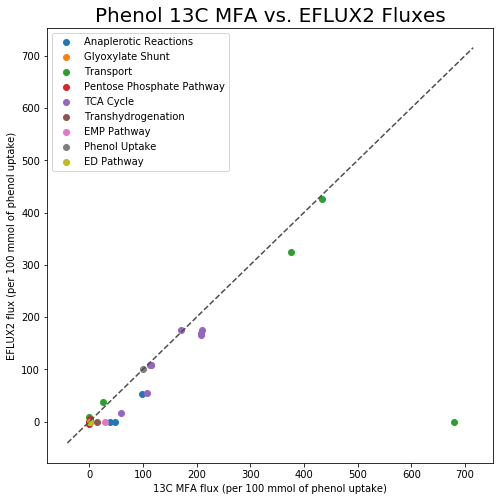

In [257]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['EFLUX2 Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. EFLUX2 Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'EFLUX2 flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

##### **For now until here!!!**

In [ ]:
# eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans2, 'WT-P-R1', 'phenol', 100)
# eflux2sol_WTPR2, spotsol_WTPR2 = eflux2spotpred(model, df_Trans2, 'WT-P-R2', 'phenol', 100)
# eflux2sol_WTPR3, spotsol_WTPR3 = eflux2spotpred(model, df_Trans2, 'WT-P-R3', 'phenol', 100)

In [ ]:
# eflux2sol_WTPR1.fluxes

In [ ]:
# eflux2sol_WTPR1_df = pd.DataFrame(eflux2sol_WTPR1.fluxes, columns=['fluxes'])
# eflux2sol_WTPR2_df = pd.DataFrame(eflux2sol_WTPR2.fluxes, columns=['fluxes'])
# eflux2sol_WTPR3_df = pd.DataFrame(eflux2sol_WTPR3.fluxes, columns=['fluxes'])
# eflux2sol_WTPR = pd.concat([eflux2sol_WTPR1_df, eflux2sol_WTPR2_df, eflux2sol_WTPR3_df], axis=1)
# eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
# eflux2sol_WTPR.mean(axis=1)
# eflux2sol_WTPR.std(axis=1)


In [ ]:
# eflux2sol_WTPR

In [ ]:
# mets = [m.id for m in model.metabolites]
# rxns = [r.id for r in model.reactions]
# nrow = len(mets)
# ncol = len(rxns)
# print(nrow, ncol)

In [ ]:
# c = [r.objective_coefficient for r in model.reactions]
# S = cobra.util.create_stoichiometric_matrix(model, array_type='DataFrame')

In [ ]:
# gpr_dict = dict()
# for r in model.reactions:
#     if r.gene_reaction_rule:
#         temp = set()
#         for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
#             temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
#         gpr_dict[r.id] = temp

## E-Flux2

### Set non-zero lower and upper bounds to 0.0 or +/-Inf

In [ ]:
# for r in model.reactions:
#     if r.lower_bound < 0.0 and r.lower_bound > -1000.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.lower_bound = -1000.0
#     elif r.lower_bound > 0.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.lower_bound = 0.0
#     elif r.upper_bound > 0.0 and r.upper_bound < 1000.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.upper_bound = 1000.0
#     elif r.upper_bound < 0.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.upper_bound = 0.0

In [ ]:
# for r in model.reactions:
#     if r.lower_bound == -1000.0:
#         r.lower_bound = -np.Inf
#     if r.upper_bound == 1000.0:
#         r.upper_bound = np.Inf

### Load transcriptomics data and calculate lower and upper bounds

In [ ]:
# lb = []
# ub = []
# for r in model.reactions:
#     if r.gene_reaction_rule:
#         t = np.sum([np.min([df_Trans2.loc[g].values if g in df_Trans2.index 
#                             else np.array([np.Inf]) for g in p])
#                     for p in gpr_dict[r.id]])
#         if r.lower_bound < 0.0:
#             lb.append(-t)
#         else:
#             lb.append(r.lower_bound)
#         if r.upper_bound > 0.0:
#             ub.append(t)
#         else:
#             ub.append(r.upper_bound)
#     else:
#         lb.append(r.lower_bound)
#         ub.append(r.upper_bound)

### Build a CPLEX model of E-Flux2 and solve

In [ ]:
# EFlux2 = cplex.Cplex()
# EFlux2.parameters.simplex.tolerances.optimality.set(1e-9)
# EFlux2.parameters.simplex.tolerances.feasibility.set(1e-9)

# EFlux2.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
# EFlux2.variables.add(obj=c, lb=lb, ub=ub, names=rxns)
# for r in model.reactions:
#     for m, v in r.metabolites.items():
#         EFlux2.linear_constraints.set_coefficients(m.id, r.id, v)
        
# EFlux2.objective.set_sense(EFlux2.objective.sense.maximize)
# EFlux2.solve()
# EFlux2_sol = EFlux2.solution.get_objective_value()
# print
# print(EFlux2.solution.get_status_string())
# print(EFlux2_sol)

### Build a CPLEX model to minimize L2 norm and solve

In [ ]:
# Q = [1.0 for r in model.reactions]

In [ ]:
# EFlux2_min = cplex.Cplex()
# EFlux2_min.parameters.simplex.tolerances.optimality.set(1e-9)
# EFlux2_min.parameters.simplex.tolerances.feasibility.set(1e-9)

# EFlux2_min.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
# EFlux2_min.variables.add(obj=[0]*ncol, lb=lb, ub=ub, names=rxns)
# for r in model.reactions:
#     for m, v in r.metabolites.items():
#         EFlux2_min.linear_constraints.set_coefficients(m.id, r.id, v)

# EFlux2_min.variables.set_lower_bounds('Growth_Phenol', 1.0*EFlux2_sol)
# EFlux2_min.objective.set_quadratic(Q)
# EFlux2_min.objective.set_sense(EFlux2_min.objective.sense.minimize)
# EFlux2_min.solve()
# EFlux2_min_sol = EFlux2_min.solution.get_objective_value()
# EFlux2_min.solution.get_status_string()

In [ ]:
#EFlux2_min.solution.get_values()

##### **Modularized way**

In [ ]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(df_Trans, linename, conditionstring):
    df_TransPhe = df_Trans[df_Trans['Line Description'].str.contains(conditionstring)]
    df_TransWTPR1 = df_TransPhe[df_TransPhe['Line Name']==linename]
    df_TransWTPR1new=df_TransWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    df_TransWTPR1new2 = df_TransWTPR1new.set_index('Measurement Type')
    return df_TransWTPR1new2

In [ ]:
constructTransdffrompred(df_Trans, linename='WT-P-R1', conditionstring='0.5 g/l PHE as carbon source')

In [ ]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2test(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
        spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return eflux2sol, spotsol

In [ ]:
eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans, 'WT-P-R1', 'phenol', 100, '0.5 g/l PHE as carbon source')

In [ ]:
#display(eflux2sol_WTPR1.fluxes['Growth_Phenol'])

In [ ]:
#spotsol_WTPR1df =pd.DataFrame(spotsol_WTPR1, columns=['fluxes'])
#spotsol_WTPR1df

In [ ]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    eflux2sol_R1, spotsol_R1 = eflux2spotpred(model, transcriptdf, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2, spotsol_R2 = eflux2spotpred(model, transcriptdf, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3, spotsol_R3 = eflux2spotpred(model, transcriptdf, linename3, substrate, sub_uptake_rate, conditionstring)
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)
    #eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    #SPOT calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    #spotsol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    spotsol = spotsol_all.mean(axis=1)
    spotsol_std = spotsol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std, spotsol, spotsol_std

In [ ]:
eflux2sol, eflux2sol_std, spotsol, spotsol_std = eflux2spotpredthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

In [ ]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['fluxes'])
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['fluxes'])

In [ ]:
eflux2soldf

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [180]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 29 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648


### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [181]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [182]:
EFLUX2_fluxes = []
SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_eflux2 = 0
    flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_eflux2 += min([get_flux_value(v, eflux2soldf) for v in and_split])
        flux_value_spot += min([get_flux_value(v,spotsoldf) for v in and_split])
    EFLUX2_fluxes.append(flux_value_eflux2)
    SPOT_fluxes.append(flux_value_spot)
    
phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

NameError: name 'eflux2soldf' is not defined

### Plot EFLUX2 vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['EFLUX2 Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. EFLUX2 Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'EFLUX2 flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

### Plot SPOT vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulatedspot_flux_list = list(pathway_df['SPOT Value'])
    
    ax.scatter(measured_flux_list, simulatedspot_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. SPOT Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'SPOT flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

In [ ]:
rxns = [r.id for r in model.reactions]
# #EFlux2_fluxdict = dict(zip(rxns,EFlux2_min.solution.get_values()))
# EFlux2_fluxdict = dict(zip(rxns,eflux2solfluxes.to_numpy()))#replace previous .get_values()
# SPOT_fluxdict = dict(zip(rxns,spotsolWTPR1.to_numpy()))#replace previous .get_values()
# #display(SPOT_fluxdict)

In [ ]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        #ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    r2_1 = np.round(1 - rss / tss,2)
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = np.round(maefunc(observed, predicted),2)
    plt.xlabel(r'EFLUX2')#Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'SPOT')#Predicted growth rates [$mmol/gDW/hr$]')
    #plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.title(r'EFLUX2 vs. SPOT ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

In [ ]:
scatterplotcompare(eflux2soldf.to_numpy(), spotsoldf.to_numpy(), labels='', strtitle='')

In [ ]:
scatterplotcompare(eflux2soldf.loc['Growth_Phenol',:], spotsoldf.loc['Growth_Phenol',:], labels='Growth', strtitle='')